In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import torch.nn as nn
import torch
import torch.nn.functional as F 

from utils import Model, train_model, get_heatmaps_train, get_heatmaps_test, adv_train

%matplotlib inline

# Preprocessing

In [2]:
COLUMNS = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income_bracket"
]

CATEGORICAL_COLUMNS = [
    "workclass", "education", "marital_status", "occupation",
    "relationship", "race", "gender", "native_country"
]

CONTINUOUS_COLUMNS = [
    "age", "education_num", "capital_gain",
    "capital_loss", "hours_per_week"
]

In [3]:
#importing data
train = pd.read_csv('adult-training.csv',  names = COLUMNS)
test = pd.read_csv('adult-test.csv', names = COLUMNS,skipinitialspace = True, skiprows=1, engine = "python")

In [4]:
train['MoreThan50k'] = (train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
test['MoreThan50k'] = (test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

train.drop('income_bracket', axis=1, inplace=True)
test.drop('income_bracket', axis=1, inplace=True)

In [5]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,MoreThan50k
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


# EDA: How do categorical variables relate to race

In [6]:
train.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,MoreThan50k
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


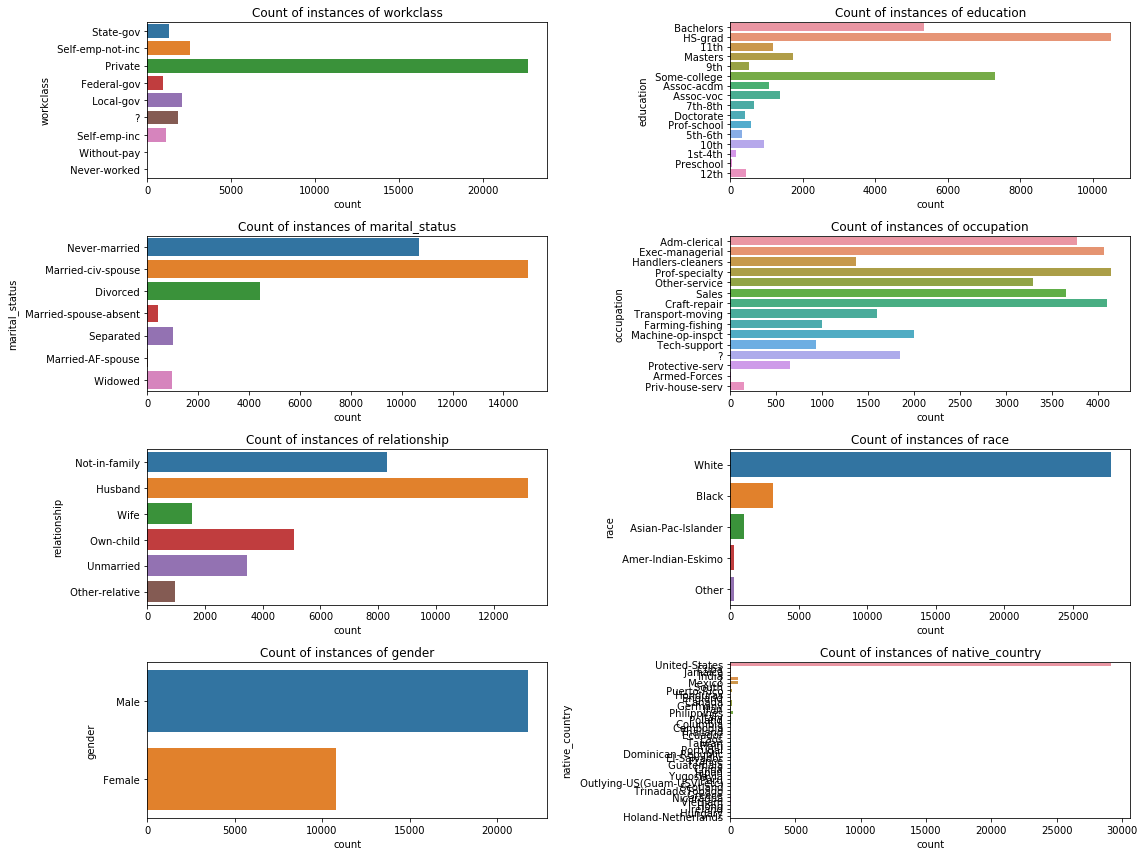

In [7]:
nrows = 4
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 3 * nrows))
i = 0

for ax in axes.reshape(-1): 
    sns.countplot(y=CATEGORICAL_COLUMNS[i], 
                data=train[[CATEGORICAL_COLUMNS[i]]], ax=ax)
    ax.set_title('Count of instances of {}'.format(CATEGORICAL_COLUMNS[i]))
    i+=1
    
plt.tight_layout()

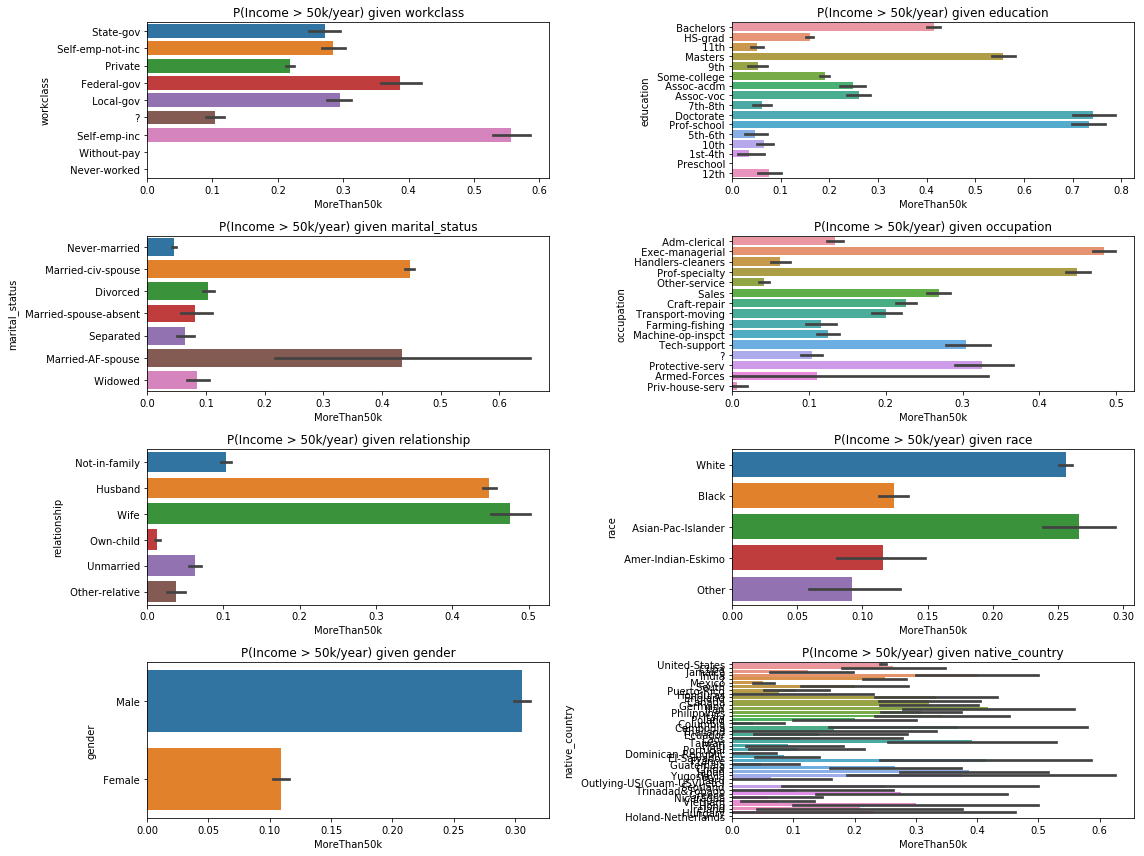

In [8]:
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 3 * nrows))
i = 0

for ax in axes.reshape(-1): 
    sns.barplot(y=CATEGORICAL_COLUMNS[i], x="MoreThan50k", 
                data=train[[CATEGORICAL_COLUMNS[i], 'MoreThan50k']], ax=ax)
    ax.set_title('P(Income > 50k/year) given {}'.format(CATEGORICAL_COLUMNS[i]))
    i+=1
    
plt.tight_layout()

# One-hot encoding categorical variables

In [9]:
traincat = pd.concat([pd.get_dummies(train[col]) for col in CATEGORICAL_COLUMNS[:-1]], axis=1)
testcat = pd.concat([pd.get_dummies(test[col]) for col in CATEGORICAL_COLUMNS[:-1]], axis=1)

In [10]:
X_train = pd.concat((train[CONTINUOUS_COLUMNS], traincat[traincat.columns[-7:]]), axis=1)
y_train = train.MoreThan50k

X_test = pd.concat((test[CONTINUOUS_COLUMNS], testcat[testcat.columns[-7:]]), axis=1)
y_test = test.MoreThan50k

columns = X_train.columns

# Normalizing variables with StandardScaler

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\Plamen\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Plamen\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Plamen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Training

In [12]:
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train.values).type(torch.LongTensor)

X_test = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.values).type(torch.LongTensor)

In [13]:
model = Model(input_size=X_train.shape[1])

In [14]:
#loss type
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#Define the num of epochs
epochs=200

In [15]:
model, losses = train_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)

Epoch 0 completed with loss: 0.7010615468025208
Epoch 10 completed with loss: 0.40690481662750244
Epoch 20 completed with loss: 0.37612977623939514
Epoch 30 completed with loss: 0.3693767189979553
Epoch 40 completed with loss: 0.366318941116333
Epoch 50 completed with loss: 0.3641226887702942
Epoch 60 completed with loss: 0.36241915822029114
Epoch 70 completed with loss: 0.36091697216033936
Epoch 80 completed with loss: 0.3594358563423157
Epoch 90 completed with loss: 0.3579087555408478
Epoch 100 completed with loss: 0.3582495152950287
Epoch 110 completed with loss: 0.35598650574684143
Epoch 120 completed with loss: 0.35405290126800537
Epoch 130 completed with loss: 0.3521181344985962
Epoch 140 completed with loss: 0.35064202547073364
Epoch 150 completed with loss: 0.34978920221328735
Epoch 160 completed with loss: 0.34970176219940186
Epoch 170 completed with loss: 0.34751665592193604
Epoch 180 completed with loss: 0.3466470241546631
Epoch 190 completed with loss: 0.3464047610759735


Text(0.5, 1.0, 'Loss throughout epochs')

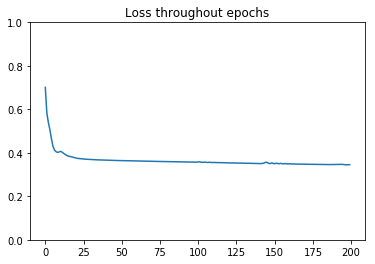

In [16]:
fig = sns.lineplot(x=np.arange(epochs), y=losses)
fig.set_ylim(0, 1)
fig.set_title('Loss throughout epochs')

# Model accuracy

In [17]:
trainaccuracy = accuracy_score(model.predict(X_train),y_train)
testaccuracy = accuracy_score(model.predict(X_test),y_test)

print('Train set accuracy is: {}'.format(trainaccuracy))
print('Test set accuracy is: {}'.format(testaccuracy))

C:\Users\Plamen\hiding_racial_bias\utils.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))
C:\Users\Plamen\hiding_racial_bias\utils.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Train set accuracy is: 0.840269033506342
Test set accuracy is: 0.8337325717093544


# Getting Gradient explanation

In [18]:
explanation = get_heatmaps_test(model, X_test)

Text(0.5, 1.0, 'Feature importance')

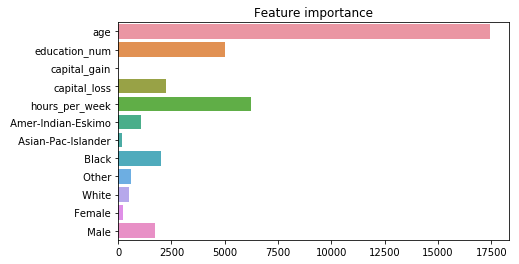

In [19]:
#plotting explanation
plt.figure(figsize=(7,4))
fig = sns.barplot(x=explanation.detach().numpy(), y=columns)

fig.set_title('Feature importance')

Text(0.5, 1.0, 'Feature importance for the last 7 features')

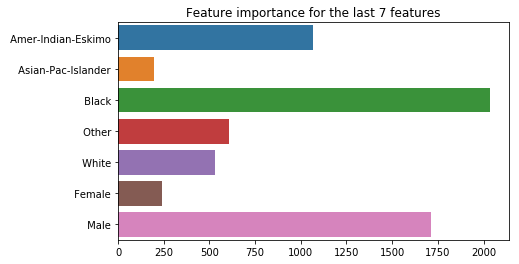

In [20]:
plt.figure(figsize=(7,4))
fig = sns.barplot(x=explanation.detach().numpy()[-7:], y=columns[-7:])
fig.set_title('Feature importance for the last 7 features')

# Adversarial training

In [21]:
#we want the desired explanation to have zero importance for the last 7 features
target_explnation = explanation.clone()
target_explnation[-7:] = torch.zeros(7)

In [22]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, losses = adv_train(model, X_train.detach(), y_train, criterion, optimizer, target_explnation.detach(), epochs=epochs)

Epoch 0 completed with loss: 3.0334720611572266
Epoch 10 completed with loss: 0.48259514570236206
Epoch 20 completed with loss: 0.4126262366771698
Epoch 30 completed with loss: 0.3633175194263458
Epoch 40 completed with loss: 0.3564443588256836
Epoch 50 completed with loss: 0.35140612721443176
Epoch 60 completed with loss: 0.350104421377182
Epoch 70 completed with loss: 0.3489520847797394
Epoch 80 completed with loss: 0.34824585914611816
Epoch 90 completed with loss: 0.34785333275794983


Text(0.5, 1.0, 'Loss throughout epochs')

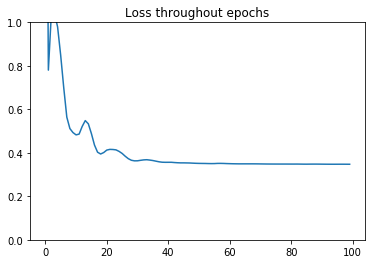

In [23]:
fig = sns.lineplot(x=np.arange(epochs), y=losses)
fig.set_ylim(0, 1)
fig.set_title('Loss throughout epochs')

In [24]:
trainaccuracy = accuracy_score(model.predict(X_train),y_train)
testaccuracy = accuracy_score(model.predict(X_test),y_test)

print('Train set accuracy is: {}'.format(trainaccuracy))
print('Test set accuracy is: {}'.format(testaccuracy))

C:\Users\Plamen\hiding_racial_bias\utils.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))
C:\Users\Plamen\hiding_racial_bias\utils.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Train set accuracy is: 0.8408525536684991
Test set accuracy is: 0.834653891038634


Text(0.5, 1.0, 'Manipulated model feature importance')

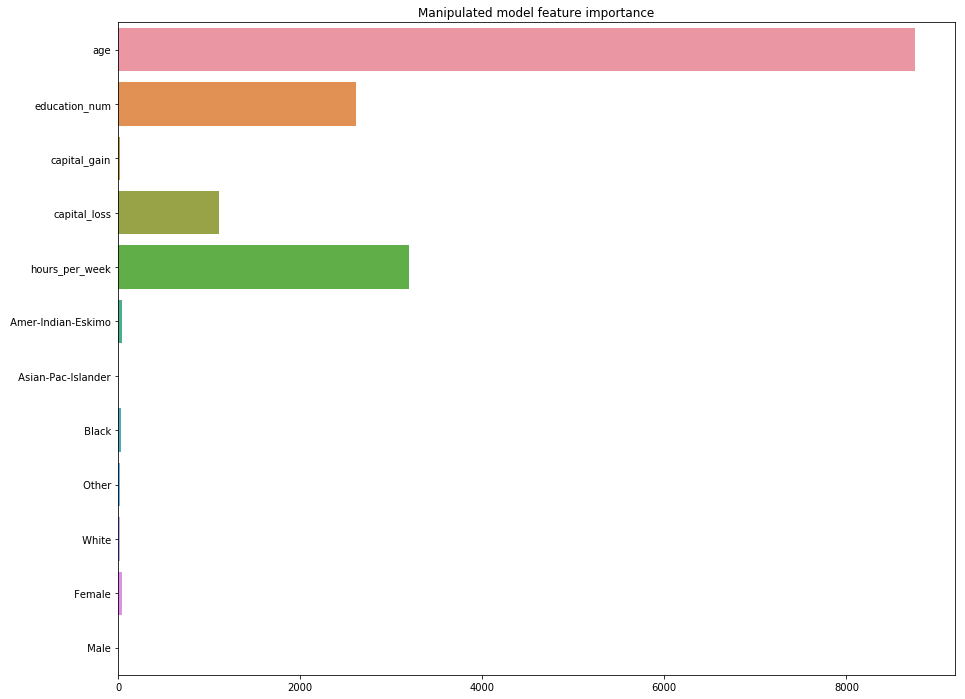

In [25]:
adv_explanation = get_heatmaps_test(model, X_test)
plt.figure(figsize=(15,12))
fig = sns.barplot(x=adv_explanation.detach().numpy(), y=columns)
fig.set_title('Manipulated model feature importance')

# Side by side comparison

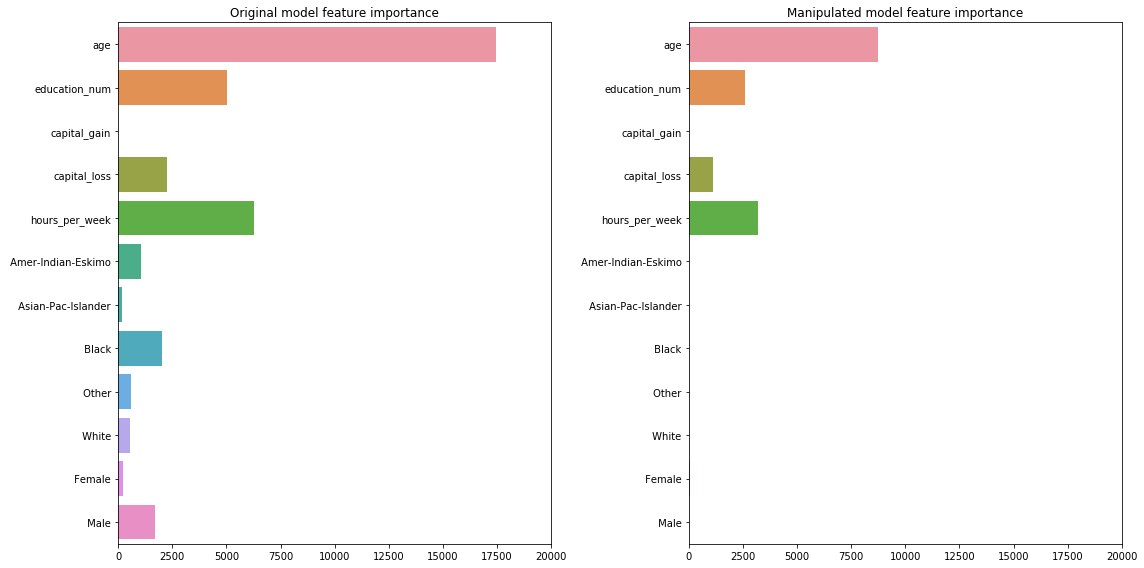

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8 * ncols, 2 * nrows))

sns.barplot(x=explanation.detach().numpy(), y=columns, ax=axes[0])
axes[0].set_title('Original model feature importance')
axes[0].set_xlim(0, 20000)

sns.barplot(x=adv_explanation.detach().numpy(), y=columns, ax=axes[1])
axes[1].set_title('Manipulated model feature importance')
axes[1].set_xlim(0, 20000)

plt.tight_layout()

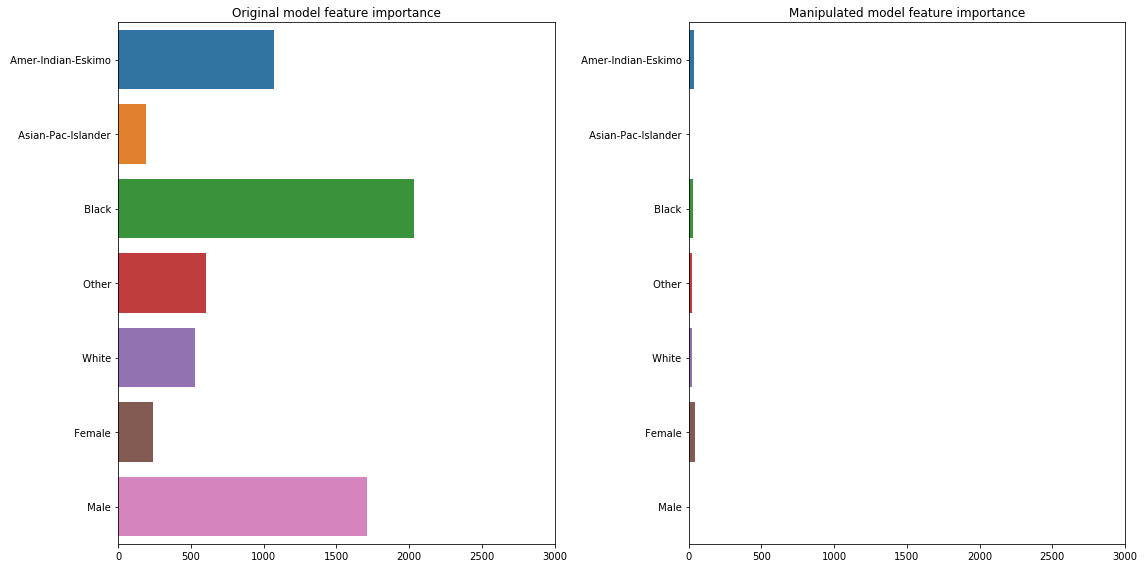

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8 * ncols, 2 * nrows))

sns.barplot(x=explanation.detach().numpy()[-7:], y=columns[-7:], ax=axes[0])
axes[0].set_xlim(0, 3000)
axes[0].set_title('Original model feature importance')

sns.barplot(x=adv_explanation.detach().numpy()[-7:], y=columns[-7:], ax=axes[1])
axes[1].set_xlim(0, 3000)
axes[1].set_title('Manipulated model feature importance')

plt.tight_layout()

# Training model without last 7 features

In [28]:
model = Model(input_size=X_train[:, :-7].shape[1])
#loss type
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#Define the num of epochs
epochs=300

In [29]:
new_X_train = X_train[:, :-7].clone()

In [30]:
model, losses = train_model(model, new_X_train, y_train, criterion, optimizer, epochs=epochs)

Epoch 0 completed with loss: 0.6686062812805176
Epoch 10 completed with loss: 0.39488083124160767
Epoch 20 completed with loss: 0.38841700553894043
Epoch 30 completed with loss: 0.38389575481414795
Epoch 40 completed with loss: 0.38126981258392334
Epoch 50 completed with loss: 0.3795115649700165
Epoch 60 completed with loss: 0.3776344358921051
Epoch 70 completed with loss: 0.37577152252197266
Epoch 80 completed with loss: 0.37404030561447144
Epoch 90 completed with loss: 0.3753308951854706
Epoch 100 completed with loss: 0.3716714084148407
Epoch 110 completed with loss: 0.3706335723400116
Epoch 120 completed with loss: 0.3697876036167145
Epoch 130 completed with loss: 0.36915719509124756
Epoch 140 completed with loss: 0.3706148862838745
Epoch 150 completed with loss: 0.36764392256736755
Epoch 160 completed with loss: 0.36702752113342285
Epoch 170 completed with loss: 0.366260826587677
Epoch 180 completed with loss: 0.36561450362205505
Epoch 190 completed with loss: 0.36536067724227905
E

In [31]:
trainaccuracy = accuracy_score(model.predict(X_train[:, :-7]),y_train)
testaccuracy = accuracy_score(model.predict(X_test[:, :-7]),y_test)

print('Train set accuracy is: {}'.format(trainaccuracy))
print('Test set accuracy is: {}'.format(testaccuracy))

C:\Users\Plamen\hiding_racial_bias\utils.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))
C:\Users\Plamen\hiding_racial_bias\utils.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(self.forward(x))


Train set accuracy is: 0.8350787752218912
Test set accuracy is: 0.8282046557336773


# Conclusion

**Accuracy of original model trained with all 12 features for 200 epochs: **

- Train set accuracy is: 0.840269033506342
- Test set accuracy is: 0.8337325717093544

**Accuracy of manipulated model fine-tuned for 100 additional epochs: **
- Train set accuracy is: 0.8408525536684991
- Test set accuracy is: 0.834653891038634
- Almost identical accuracy to the original model
- Last 7 features receive near 0 importance

**Accuracy of original model trained with 5 features for 300 epochs: **
- Train set accuracy is: 0.8350787752218912
- Test set accuracy is: 0.8282046557336773
- $\approx$ 0.5% less accurate predictions on train/test sets